In [2]:
# @title: imports, and graphics setup
import sys
sys.path.append('..')
from multiprocessing import Pool, TimeoutError
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.colors as mcol
import matplotlib.cm as cm
import numpy as np
import mpmath as mp
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy import integrate as integrate
from Modules.potential_operations import histogram_potential_fitter, normalized_pdf_from_potential, generate_theoretical_pdf_for_fit
from Modules.custom_simulations import simulate_particles_in_external_force_Not_HOOMD
import warnings
from scipy.optimize import fsolve
from tqdm.auto import tqdm, trange
from Modules.pdfs import *
from joblib import Parallel, delayed
import re

%matplotlib inline
matplotlib.style.use('default')
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

In [3]:
from Modules.potentials import harmonic_potential
from Modules.forces import harmonic_force

In [4]:
def run_simulation(n_particles, steps, x_start_position, force ,force_args, delta_fraction,dt, kT, gamma):
    start_position=x_start_position
    args = [force, n_particles, steps, delta_fraction]
    trajectories = simulate_particles_in_external_force_Not_HOOMD(*args, dt=dt, kT=kT, force_args=force_args, start_position=start_position, gamma=gamma, type=np.float32)
    x_positions = np.array(trajectories)
    return x_positions

#### units conv

In [5]:
real_k_conv_factor = 1e-6

dt = 0.1
def convert_arbitrary_time_to_seconds(sim_gamma, real_k_conv_factor=1e-6, real_R=0.5*1e-6):
    water_viscosity = 0.00089
    real_gamma = 6 * np.pi * water_viscosity * real_R
    real_time_scale = real_gamma/real_k_conv_factor
    sim_time_scale = sim_gamma/1
    real_time =  real_time_scale/sim_time_scale #units: sec/sim_time
    return real_time #units: sec/sim_time

print('Real dt =',dt*convert_arbitrary_time_to_seconds(500, real_k_conv_factor=1*1e-6, real_R=0.5*1e-6), 'seconds')


print('Real k =',5*real_k_conv_factor, 'pN/um')

Real dt = 1.6776104770169494e-06 seconds
Real k = 4.9999999999999996e-06 pN/um


#### help funcs

In [6]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input: 
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def resample_trajectories(trajectories, resample_size, seed):
    if resample_size == trajectories.shape[1]:
        return trajectories
    rng = np.random.default_rng(seed) # reproducible results
    N = trajectories.shape[1]
    idx = rng.integers(N, size=resample_size)     # vectorized draw
    return np.take(trajectories, idx, axis=1)

def _process_timestep_to_kld(timestep, x_pos, n_samples, bins, target_distribution):
    if timestep != 0:
        histogram, _ = np.histogram(x_pos[timestep:timestep+n_samples], bins=bins, density=True)
    else:
        histogram, _ = np.histogram(x_pos[timestep:timestep+1], bins=bins, density=True)
    # Add a small constant to avoid division by zero
    histogram += 1e-10
    target_distribution += 1e-10
    kld = stats.entropy(target_distribution,histogram)
    nans, x = nan_helper(kld)
    if np.sum(nans) != 0:
        kld[nans] = np.interp(x(nans), x(~nans), np.array(kld)[~nans])
    return kld

def estimate_kld_per_timestep(trajectories, bins, timesteps, n_samples, n_target_distribution_samples, resample_size = None, n_resamples=None, seed=None):
    klds_per_timestep_per_resample = []
    print('starting resampling and kld estimation')
    for i in range(n_resamples):
        if resample_size is not None and n_resamples is not None:
            if seed is not None:
                seed = np.random.randint(0, 1e6)
            x_pos = resample_trajectories(trajectories, resample_size, seed)
        else:
            x_pos = trajectories
        target_distribution_points = x_pos[-n_target_distribution_samples:]
        target_distribution, _ = np.histogram(target_distribution_points, bins=bins, density=True)
        klds_per_timestep_single = []
        klds_per_timestep_single = Parallel(n_jobs=-1)(delayed(_process_timestep_to_kld)(timestep, x_pos, n_samples, bins, target_distribution) for timestep in timesteps)
        klds_per_timestep_per_resample.append(klds_per_timestep_single)
        print(f'finished resample {i+1} of {n_resamples}')
    return np.array(klds_per_timestep_per_resample)

def calculate_threshold_from_kld(klds, n_sigmas=10, ss_timesteps=50):
    kld_threshold = np.min(klds[-ss_timesteps:])
    kld_threshold_std = np.std(klds[-ss_timesteps:])
    kld_threshold = kld_threshold + n_sigmas*kld_threshold_std
    return kld_threshold

def _calculate_plateau_index(kld_per_time, timesteps, n_sigmas=10, ss_steps=50):
    kld_threshold = calculate_threshold_from_kld(kld_per_time, n_sigmas=n_sigmas, ss_timesteps=ss_steps)
    plateau_index = np.where(kld_per_time < kld_threshold)[0][0]
    timestep_plateau = timesteps[plateau_index]*dt
    return timestep_plateau

def estimate_relaxation_time_from_kld(klds_per_timestep_per_resample, timesteps, n_sigmas=10, ss_steps=50):
    plateaus = []
    plateaus = Parallel(n_jobs=-1)(delayed(_calculate_plateau_index)(kld_per_time, timesteps, n_sigmas=n_sigmas, ss_steps=ss_steps) for kld_per_time in klds_per_timestep_per_resample)
    mean_plateau = np.mean(plateaus)
    std_plateau = np.std(plateaus)
    return mean_plateau, std_plateau

def calculate_relaxation_time_per_batch_per_rate(trajectories, bins, timesteps, n_samples, n_target_distribution_samples, n_sigmas=10, ss_timesteps=50, resample_size = None, n_resamples=None, seed=None):
    klds_per_timestep_per_resample = estimate_kld_per_timestep(trajectories, bins, timesteps, n_samples, n_target_distribution_samples, resample_size=resample_size, n_resamples=n_resamples, seed=seed)
    print('estimated klds per timestep per resample')
    mean_plateau, std_plateau = estimate_relaxation_time_from_kld(klds_per_timestep_per_resample, timesteps, n_sigmas=n_sigmas, ss_steps=ss_timesteps)
    print('estimated relaxation time from kld')
    return mean_plateau, std_plateau

def calculate_relaxation_time_per_folder(folder, bins, timesteps, n_samples, n_target_distribution_samples, n_sigmas=10, ss_timesteps=50, batches=-1, resample_size = None, n_resamples=None, seed=None):
    if batches == 0:
        return None
    c = 0
    relaxation_times_per_batch = []
    stds_per_batch = []
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            print(f'read file {filename}, shape: {trajectories_per_r.shape}')
            relaxation_times_per_rate = []
            stds_per_rate = []
            for trajectories in trajectories_per_r:
                mean_plateau, std_plateau = calculate_relaxation_time_per_batch_per_rate(trajectories, bins, timesteps, n_samples, n_target_distribution_samples, n_sigmas=n_sigmas, ss_timesteps=ss_timesteps, resample_size=resample_size, n_resamples=n_resamples, seed=seed)
                relaxation_times_per_rate.append(mean_plateau)
                stds_per_rate.append(std_plateau)
                print(f'calculated relaxation time: {mean_plateau} +/- {std_plateau}')
            relaxation_times_per_rate = np.array(relaxation_times_per_rate)
            stds_per_rate = np.array(stds_per_rate)
            np.save(folder+f'/relaxation_times_batch_{c+1}.npy', relaxation_times_per_rate)
            np.save(folder+f'/stds_batch_{c+1}.npy', stds_per_rate)
            relaxation_times_per_batch.append(relaxation_times_per_rate)
            stds_per_batch.append(stds_per_rate)
            del trajectories_per_r
            c+=1
            if batches != -1 and batches == c:
                break
            else:
                print(f'finished batch {c} of {batches}')
    print(f'finished all {c} batches')
    relaxation_times_per_batch = np.array(relaxation_times_per_batch)
    stds_per_batch = np.array(stds_per_batch)
    return relaxation_times_per_batch, stds_per_batch

def _calculate_single_mean_var(x_pos):
    mean = np.mean(x_pos, axis=1)
    var = np.var(x_pos, axis=1)
    return mean, var

def calculate_mean_var_trajectory_per_rate(trajs):
    # Using parallel processing for each trajectory
    #means_vars_per_pos = Parallel(n_jobs=-1, prefer='threads')(
    #    delayed(_calculate_single_mean_var)(x_pos) for x_pos in trajs
    #)
    ### not parallel version
    means_vars_per_pos = []
    for x_pos in trajs:
        means_vars_per_pos.append(_calculate_single_mean_var(x_pos))
    return np.array(means_vars_per_pos)

def _calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_timestep = []
    target_distribution_points = x_pos[-n_target_distribution_samples:]
    target_distribution, _ = np.histogram(target_distribution_points, bins=bins, density=True)
    for timestep in timesteps:
        if timestep != 0:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+n_samples], bins=bins, density=True)
        else:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+1], bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        histograms_per_timestep.append([histogram, bin_centers])
    histograms_per_timestep.append([target_distribution, bin_centers])
    return histograms_per_timestep

def generate_histograms_per_rate(trajs, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_rate = []
    histograms_per_rate = Parallel(n_jobs=-1, prefer='threads')(delayed(_calculate_single_histogram)(x_pos, bins, timesteps, n_samples, n_target_distribution_samples) for x_pos in trajs)
    '''
    for x_pos in trajs:
        histograms_per_rate.append(_calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples))
    histograms_per_rate = np.array(histograms_per_rate)
    '''
    return histograms_per_rate


def calculate_average_measure_per_batches(folder, measure, batches=-1, args=[]):
    if batches == 0:
        return None
    c = 0
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            if c == 0:
                if measure != generate_histograms_per_rate:
                    value = measure(trajectories_per_r, *args)
                else:
                    value = np.array(measure(trajectories_per_r, *args))
            else:
                if measure != generate_histograms_per_rate:
                    value += measure(trajectories_per_r, *args)
                else:
                    value += np.array(measure(trajectories_per_r, *args))
            c+=1
            if batches != -1 and batches == c:
                break
            del trajectories_per_r
            if batches == -1:
                print(f'finished batch {c}')
            else:
                print(f'finished batch {c} of {batches}')
            if batches != -1 and batches == c:
                break
    if measure != generate_histograms_per_rate:
        final_value = value/c
    else:
        final_value = np.array(value)/c
    return final_value

def extract_final_ensemble_state(folder, batches=-1):
    if batches == 0:
        return None
    c = 0
    ensemble_state_per_rate = []
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            if c == 0:
                ensemble_state_per_rate = [traj[-1] for traj in trajectories_per_r]
            else:
                for i, traj in enumerate(trajectories_per_r):
                    ensemble_state_per_rate[i] = np.concatenate((ensemble_state_per_rate[i], traj[-1]))
            c+=1
            if batches != -1 and batches == c:
                break
    ensemble_state_per_rate = np.array(ensemble_state_per_rate)
    return ensemble_state_per_rate

def extract_ensamble_state_at_indices(folder, indices, batches=-1):
    if batches == 0:
        return None
    c = 0
    ensemble_state_per_rate = []
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            if c == 0:
                ensemble_state_per_rate = [traj[index] for traj, index in zip(trajectories_per_r, indices)]
            else:
                for i, (traj, index) in enumerate(zip(trajectories_per_r, indices)):
                    #print('traj shape:', traj.shape, 'index:', index, 'traj[index] shape:', traj[index].shape)
                    ensemble_state_per_rate[i] = np.concatenate((ensemble_state_per_rate[i], traj[index]))
            c+=1
            if batches != -1 and batches == c:
                break
    ensemble_state_per_rate = np.array(ensemble_state_per_rate)
    return ensemble_state_per_rate
    

### Simulations

In [15]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 20000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]
typical_relaxation_time = gamma/k_harm
typical_length_scale = np.sqrt(kT/k_harm)

### a few starting positions (for speedup vs. S) ###
start_positions_sigmas = np.array([0, 0.1, 0.3, 1, 3])
start_positions = -start_positions_sigmas * typical_length_scale
start_positions_str = [f'{pos:.3f}'[1:] for pos in start_positions]
start_positions_str = ','.join(start_positions_str)
print('start_positions:', start_positions)

### resetting parameters ### 
### linear spacing speedup vs. S ###
S_ratios = np.concatenate((np.linspace(0, 2, 5), np.linspace(2, 5, 4)[1:]))
print('S_ratios:', S_ratios)
delta_fractions = (k_harm*S_ratios/gamma)*dt
resetting_rates = delta_fractions/dt


colors = cm.rainbow(np.linspace(0, 1, len(delta_fractions)))

sherf_nums = gamma*resetting_rates/k_harm
print('Sherf numbers:', sherf_nums)

resetting_rates_str = [f'{rate:.2f}'[1:] for rate in resetting_rates]
resetting_rates_str = ','.join(resetting_rates_str)
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}'
if k_harm != 5:
    folder += f'_k={k_harm}'
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
print('Folder -', folder)
print('Subfolders -', subfolders)

start_positions: [-0.         -0.04472136 -0.13416408 -0.4472136  -1.34164079]
S_ratios: [0.  0.5 1.  1.5 2.  3.  4.  5. ]
Sherf numbers: [0.  0.5 1.  1.5 2.  3.  4.  5. ]
Folder - HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342
Subfolders - ['HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.000', 'HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.045', 'HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.134', 'HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.447', 'HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--1.342']


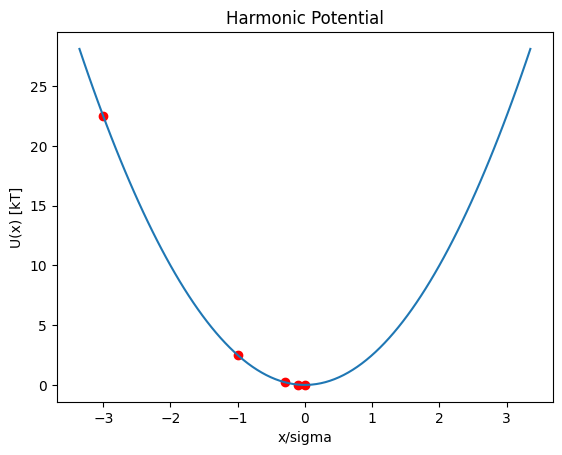

In [13]:
### plot potential ###
potential_x_unnormalized = np.linspace(-1.5, 1.5, 100)
potential_y_unnormalized = harmonic_potential(potential_x_unnormalized, k_harm)
potential_x = potential_x_unnormalized/typical_length_scale
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y)
plt.scatter(start_positions/typical_length_scale, harmonic_potential(start_positions/typical_length_scale, k_harm)/kT, color='red', label='Start Positions')
plt.xlabel('x/sigma')
plt.ylabel('U(x) [kT]')
plt.title('Harmonic Potential')
plt.show()

In [17]:
#raise KeyboardInterrupt
### Run simulations ###
os.makedirs(folder, exist_ok=True)
print([int(a) for a in np.arange(0 , n_particles, batch_size)])
if __name__ == "__main__":
    for start_position, subfolder in zip(start_positions, subfolders):
        os.makedirs(subfolder, exist_ok=True)
        print('Subfolder:', subfolder)
        filenames = os.listdir(subfolder)
        existing_batches = 0 
        for file in filenames:
            if re.search("^batch.*npy", file):
                nums = re.findall((r'\d+'), file)
                n = ''.join(nums)
                if int(n) > existing_batches:
                    existing_batches = int(n)
        print("Existing Batches: ", existing_batches)
        for _ in np.arange(0 , n_particles, batch_size):
            simulation_parameters = [(batch_size, steps, start_position, harmonic_force, force_args, delta_fraction, dt, kT, gamma) for delta_fraction in delta_fractions]
            trajectories_per_rate = Parallel(n_jobs=-1, verbose = 1, backend='threading')(delayed(run_simulation)(*args) for args in simulation_parameters)
            np.save(subfolder+f'/batch_{int(_/batch_size)+1+existing_batches}.npy', trajectories_per_rate)
            print(f'Finished {_+batch_size} particles')
    print('Finished all particles')

[0, 10000]
Subfolder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.000
Existing Batches:  0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.3s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.8s finished


Finished 10000 particles


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.2s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.5s finished


Finished 20000 particles
Subfolder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.045
Existing Batches:  0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.4s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.9s finished


Finished 10000 particles


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.2s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.7s finished


Finished 20000 particles
Subfolder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.134
Existing Batches:  0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.4s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.8s finished


Finished 10000 particles


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.2s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.6s finished


Finished 20000 particles
Subfolder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.447
Existing Batches:  0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.1s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.5s finished


Finished 10000 particles


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.4s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.5s finished


Finished 20000 particles
Subfolder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--1.342
Existing Batches:  0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.1s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.7s finished


Finished 10000 particles


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.2s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.7s finished


Finished 20000 particles
Finished all particles


In [18]:
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}'
if k_harm != 5:
    folder += f'_k={k_harm}'
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
filenames = os.listdir(subfolders[0])
trajectories = np.load(subfolders[0] + '/' + filenames[0], allow_pickle=True)
trajectories_per_rate_per_start = np.array(trajectories)

In [19]:
trajectories_per_rate_per_start = np.array(trajectories_per_rate)

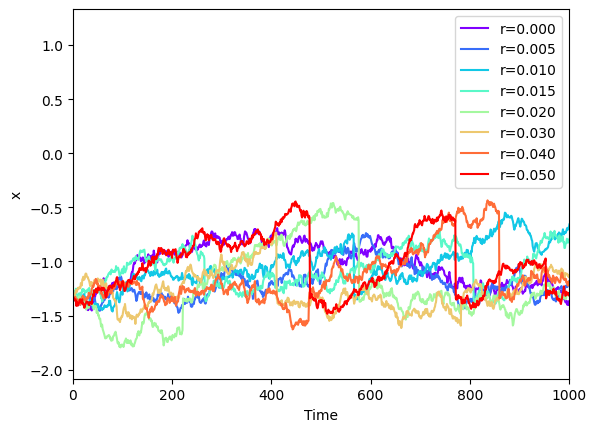

In [20]:
### plot trajectories ###
for i, [rate, trajs] in enumerate(zip(resetting_rates, trajectories_per_rate_per_start)):
    plt.plot(np.arange(steps), trajs[:, 0], label=f'r={rate:.3f}', color=colors[i])
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.xlim(0, 1000)
plt.show()

##### moments analysis

In [21]:
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}'
if k_harm != 5:
    folder += f'_k={k_harm}'
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]

for subfolder in tqdm(subfolders):
    means_vars = calculate_average_measure_per_batches(subfolder, calculate_mean_var_trajectory_per_rate, batches=-1)
    means = means_vars[:, 0]
    vars = means_vars[:, 1]
    np.save(subfolder+'/mean_trajectories.npy', means)
    np.save(subfolder+'/var_trajectories.npy', vars)

  0%|          | 0/5 [00:00<?, ?it/s]

finished batch 1
finished batch 2
finished batch 1
finished batch 2
finished batch 1
finished batch 2
finished batch 1
finished batch 2
finished batch 1
finished batch 2


In [22]:
### load means and variances per start position ###
means_per_start = []
vars_per_start = []
for subfolder in subfolders:
    means = np.load(subfolder+'/mean_trajectories.npy')
    vars = np.load(subfolder+'/var_trajectories.npy')
    means_per_start.append(means)
    vars_per_start.append(vars)
means_per_start = np.array(means_per_start)
vars_per_start = np.array(vars_per_start)

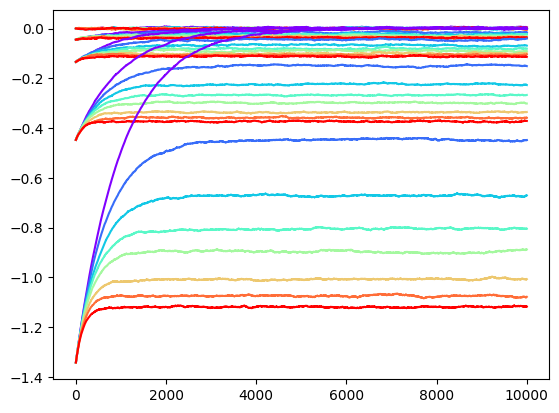

In [23]:
### plot mean per r ### 
for means, start_position in zip(means_per_start, start_positions):
    for c,mean_traj in zip(colors,means):
        plt.plot(mean_traj, color=c)
plt.show()

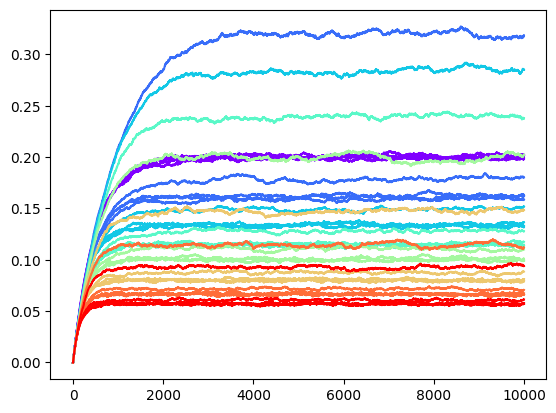

In [24]:
### plot vars per start ### 
for vars, start_position in zip(vars_per_start, start_positions):
    for c,vars_traj in zip(colors,vars):
        plt.plot(vars_traj, color=c)
plt.show()

##### pdf analysis

In [25]:
resetting_colors = cm.rainbow(np.linspace(0, 1, len(resetting_rates)))

In [26]:
samples = 5
target_distribution_samples = 500
steady_state = 8000
timesteps = np.arange(0, steady_state, 5)

In [27]:
bins_per_start_pos = []
for subfolder in tqdm(subfolders):
    bins_max = -np.inf
    bins_min = np.inf
    filenames = os.listdir(subfolder)
    for filename in filenames:
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories = np.load(subfolder+'/'+filename, allow_pickle=True)
            bin_edges_strong_res = np.histogram_bin_edges(trajectories[-1][-target_distribution_samples:], bins=201)
            bins_min_strong_res = bin_edges_strong_res[0]
            bins_max_strong_res = bin_edges_strong_res[-1]
            bin_edges_no_reset = np.histogram_bin_edges(trajectories[0][-target_distribution_samples:], bins=201)
            bins_min_no_reset = bin_edges_no_reset[0]
            bins_max_no_reset = bin_edges_no_reset[-1]
            bins_max = max(bins_max_strong_res, bins_max_no_reset, bins_max)
            bins_min = min(bins_min_strong_res, bins_min_no_reset, bins_min)
            bins = np.linspace(bins_min*1.5, bins_max*1.5, 201)
            bins_per_start_pos.append(bins)
            break
bins_per_start_pos = np.array(bins_per_start_pos)
np.save(folder+'/bins_per_start_pos.npy', bins_per_start_pos)    


  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
bins_per_start_pos = np.load(folder+'/bins_per_start_pos.npy', allow_pickle=True)

In [29]:
print('bins_per_start_pos:', bins_per_start_pos)

bins_per_start_pos: [[-2.8575797 -2.8280241 -2.7984686 ...  2.99442    3.0239754  3.0535312]
 [-3.1503773 -3.1201105 -3.0898438 ...  2.8424463  2.872713   2.9029799]
 [-2.853715  -2.824586  -2.7954571 ...  2.9138193  2.9429483  2.9720774]
 [-2.829513  -2.8007164 -2.7719197 ...  2.8722386  2.9010358  2.9298325]
 [-3.7497618 -3.7154233 -3.6810849 ...  3.049257   3.0835955  3.1179342]]


In [30]:
bins_per_start_pos = np.load(folder+'/bins_per_start_pos.npy', allow_pickle=True)
for subfolder, bins in tqdm(zip(subfolders, bins_per_start_pos)):
    args = [bins, timesteps, samples, target_distribution_samples]
    histograms_per_rate = calculate_average_measure_per_batches(subfolder, generate_histograms_per_rate, args=args, batches=-1)
    np.save(subfolder+'/histograms_per_rate.npy', histograms_per_rate)

0it [00:00, ?it/s]

finished batch 1
finished batch 2
finished batch 1
finished batch 2
finished batch 1
finished batch 2
finished batch 1
finished batch 2
finished batch 1
finished batch 2


In [31]:
#### Load histograms per rate per start ###
histograms_per_rate_per_start = []
for subfolder in subfolders:
    histograms_per_rate = np.load(subfolder+'/histograms_per_rate.npy', allow_pickle=True)
    histograms_per_rate_per_start.append(histograms_per_rate)
histograms_per_rate_per_start = np.array(histograms_per_rate_per_start)

In [32]:
os.makedirs(folder, exist_ok=True)
with open(os.path.join(folder, 'histograms_per_rate_per_start.npy'), 'wb') as f:
    np.save(f, histograms_per_rate_per_start)

In [33]:
histograms_per_rate_per_start = np.load(os.path.join(folder, 'histograms_per_rate_per_start.npy'), allow_pickle=True)

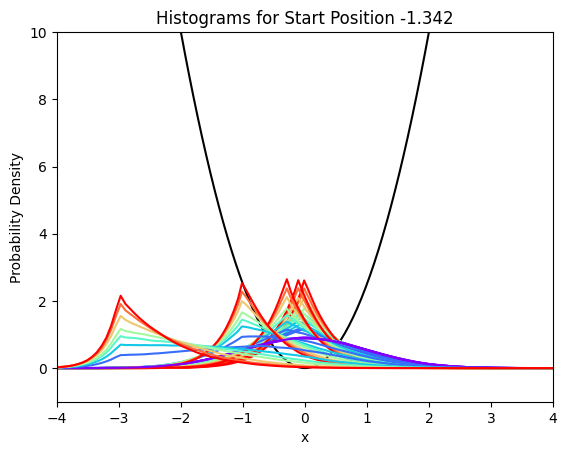

In [40]:
### plot histograms per rate per start ###
plt.plot(potential_x, potential_y, label='Harmonic Potential', color='black')
for i, histograms_per_rate in enumerate(histograms_per_rate_per_start):
    for j, (hists_per_time, c) in enumerate(zip(histograms_per_rate, resetting_colors)):
        histogram, bin_centers = hists_per_time[-1] ## ss distribution
        plt.plot(bin_centers/typical_length_scale, histogram, label=f'Start {i+1}, Rate {j+1}', color=c)
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title(f'Histograms for Start Position {start_positions[i]:.3f}')
plt.xlim(-4, 4)
plt.ylim(-1, 10)
plt.show()

In [13]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [57]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b",'purple',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(resetting_rates),vmax=max(resetting_rates))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

colors_resetting = [cpick.to_rgba(rate) for rate in resetting_rates]

##### PDF animations

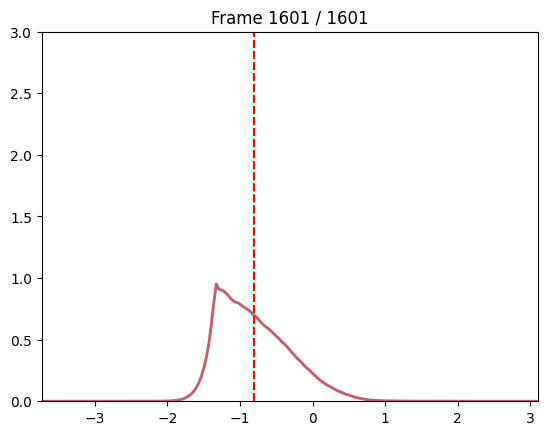

In [47]:
from matplotlib.animation import FuncAnimation

# Load bins_per_start_pos and subfolders
bins_per_start_pos = np.load(folder + '/bins_per_start_pos.npy', allow_pickle=True)

# Set up the figure
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, alpha=0.5)
line2, = ax.plot([], [], lw=2, alpha=0.5, color='red')
vline_mean = ax.axvline(0, color='black', linestyle='--', label='Mean')  # initialized but invisible
vline_ss = ax.axvline(0, color='red', linestyle='--', label='Steady State Mean')

# Select subfolder and load histogram data
c = 0
for bins, subfolder in zip(bins_per_start_pos, subfolders):
    if c == 4:
        histograms_per_rate = np.load(subfolder + '/histograms_per_rate.npy', allow_pickle=True)
        means_per_rate = np.load(subfolder + '/mean_trajectories.npy', allow_pickle=True)
        break
    c += 1

indx = 3
histograms = histograms_per_rate[indx]
means = means_per_rate[indx]
mean_per_timestep = means[np.arange(0, steady_state+1, 5)]

# Initialize function for animation
def init():
    line.set_data([], [])
    return line,

# Animation update function
def update(i):
    hist, bin = histograms[i, 0], histograms[i, 1]
    hist_ss, bin_ss = histograms[-1, 0], histograms[-1, 1]
    mean = mean_per_timestep[i]
    mean_ss = mean_per_timestep[-1]
    line.set_data(bin, hist)
    line2.set_data(bin_ss, hist_ss) 
    vline_mean.set_xdata([mean, mean])
    vline_ss.set_xdata([mean_ss, mean_ss])
    ax.set_xlim(np.min(bin), np.max(bin))
    ax.set_ylim(0, 3)  # Small buffer above max
    ax.set_title(f"Frame {i+1} / {len(histograms)}")
    return line, line2,# vline_mean, vline_ss,

# Create animation
ani = FuncAnimation(fig, update, frames=len(histograms), init_func=init, blit=True, interval=100)

# Optional: save to file
ani.save(f"histogram_animation_xsigma_{start_positions_sigmas[c]}_s_{sherf_nums[indx]}.gif", writer="ffmpeg")

plt.show()


#####  NO Batches Analysis Of KLD relaxation 


In [48]:
###  NO Batches Analysis Of KLD relaxation ###
#raise KeyboardInterrupt

KLDs_per_rate_per_start = []

for histograms_per_rate in histograms_per_rate_per_start:
    KLDs_per_rate = []
    for histograms_per_time, resetting_rate in zip(histograms_per_rate, resetting_rates):
        KLDs_by_time_per_rate = []
        shift = 0
        x_intercept = 0
        delta_fraction = resetting_rate*dt
        harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
        eps = 1e-10
        pdf_values = histograms_per_time[-1][0] + eps

        for hist, bin_centers in histograms_per_time[:-1]:
            hist = hist + eps
            kld = stats.entropy(pdf_values, hist)
            KLDs_by_time_per_rate.append(kld)
            
        KLDs_by_time_per_rate = np.array(KLDs_by_time_per_rate)
        nans, x = nan_helper(KLDs_by_time_per_rate)
        if np.sum(nans) != 0:
            KLDs_by_time_per_rate[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_time_per_rate)[~nans])
        KLDs_per_rate.append(KLDs_by_time_per_rate)
    KLDs_per_rate = np.array(KLDs_per_rate)
    KLDs_per_rate_per_start.append(KLDs_per_rate)
KLDs_per_rate_per_start = np.array(KLDs_per_rate_per_start)
np.save(folder+'/KLDs_per_rate_per_start.npy', KLDs_per_rate_per_start)

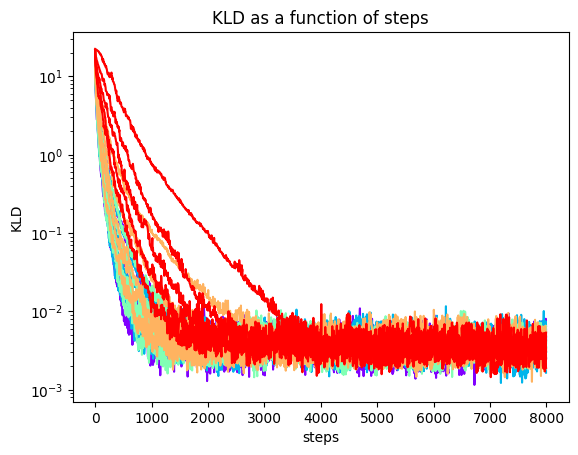

In [50]:
### plot KLDs ###

colors_starting = cm.rainbow(np.linspace(0, 1, len(start_positions)))

timesteps = np.arange(0, steady_state, 5)
for i, (KLDs_per_rate, c_start) in enumerate(zip(KLDs_per_rate_per_start, colors_starting)):
    for j, (kld_per_time, r, c) in enumerate(zip(KLDs_per_rate, resetting_rates, colors)):
        plt.semilogy(timesteps,kld_per_time, label=f'{r:.3f}', color=c_start)
        if j == 4:
            break
    plt.xlabel('steps')
    plt.ylabel('KLD')
    plt.title('KLD as a function of steps')
plt.show()

In [54]:
kld_thresholds_per_start = []
for KLDs_per_rate in KLDs_per_rate_per_start:
    kld_thresholds = []
    for kld_per_time in KLDs_per_rate:
        kld_threshold = np.min(kld_per_time[-50:])
        kld_threshold_std = np.std(kld_per_time[-50:])
        kld_threshold = kld_threshold + 10*kld_threshold_std
        kld_thresholds.append(kld_threshold)
    kld_threshold = max(kld_thresholds)
    kld_thresholds_per_start.append(kld_threshold)
kld_thresholds_per_start = np.array(kld_thresholds_per_start)
print('KLD Thresholds per start position:', kld_thresholds_per_start)

KLD Thresholds per start position: [0.01402543 0.01699064 0.01431217 0.01385928 0.01138687]


In [55]:
platue_index_per_r_per_start = []
for KLDs_per_rate, kld_threshold in zip(KLDs_per_rate_per_start, kld_thresholds_per_start):
    platue_index_per_r = []
    for kld_per_time, r, c in zip(KLDs_per_rate, resetting_rates, colors):
        platue_index = np.where(kld_per_time < kld_threshold)[0][0]
        timestep_platue = timesteps[platue_index]*dt
        platue_index_per_r.append(timestep_platue)
    platue_index_per_r = np.array(platue_index_per_r)
    platue_index_per_r_per_start.append(platue_index_per_r)
platue_index_per_r_per_start = np.array(platue_index_per_r_per_start)
np.save(folder+'/platue_index_per_r_per_start.npy', platue_index_per_r_per_start)

##### Batched Analysis of the KLD relaxation

In [60]:
samples = 5
target_distribution_samples = 500
steady_state = 8000
timesteps = np.arange(0, steady_state, 5)
histograms_per_start_pos = []
bins_per_start_pos = np.load(folder+'/bins_per_start_pos.npy', allow_pickle=True)

In [61]:
### Characterize Steady State Index of the KLDs using batches to estimate error bars ###
histograms_per_BRT_per_start = [] #Batch Rate Time
batches_to_process = -1
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}' 
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
for f, bins in tqdm(zip(subfolders, bins_per_start_pos)):
    total_batches = 0
    for filename in os.listdir(f):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            total_batches += 1
    if batches_to_process < 0 or batches_to_process > total_batches:
        batches_to_process = total_batches
    print('Processing folder:', f)
    histograms_per_BRT = [] #Batch Rate Time
    processed_batches = 0
    for filename in os.listdir(f):
        histograms_per_RT = []
        check_if_batch_file =  re.search("^batch", filename) != None
        batch_found = ''.join(re.findall(r'\d', filename))
        if check_if_batch_file:
            trajectories = np.load(f+'/'+filename)
            trajectories_per_r = np.array(trajectories)
            del trajectories
            histograms_per_RT = generate_histograms_per_rate(trajectories_per_r, bins, timesteps, samples, target_distribution_samples)
            del trajectories_per_r
            histograms_per_BRT.append(histograms_per_RT)
            processed_batches += 1
        #print(f'Finished batch {processed_batches} of {batches_to_process}')
        if processed_batches >= batches_to_process:
            break
    histograms_per_BRT = np.array(histograms_per_BRT)
    np.save(f+'/histograms_per_BRT.npy', histograms_per_BRT)
    histograms_per_BRT_per_start.append(histograms_per_BRT)
histograms_per_BRT_per_start = np.array(histograms_per_BRT_per_start)
np.save(folder+'/histograms_per_BRT_per_start.npy', histograms_per_BRT_per_start)

0it [00:00, ?it/s]

Processing folder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.000
Processing folder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.045
Processing folder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.134
Processing folder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.447
Processing folder: HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--1.342


In [62]:
histograms_per_BRT_per_start = np.load(folder+'/histograms_per_BRT_per_start.npy', allow_pickle=True)

In [63]:
###  Batched Analysis Of KLD relaxation ###


KLDs_per_BR_per_start = []
for histograms_per_BRT in histograms_per_BRT_per_start:
    KLDs_per_BR = []
    for i, histograms_per_RT in tqdm(enumerate(histograms_per_BRT)):
        KLDs_per_R = []
        for histograms_per_time, resetting_rate in zip(histograms_per_RT, resetting_rates):
            KLDs_by_TR = []
            shift = 0
            x_intercept = 0
            delta_fraction = resetting_rate*dt
            harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
            eps = 1e-10
            pdf_values = histograms_per_time[-1][0] + eps

            for hist, bin_centers in histograms_per_time[:-1]:
                hist = hist + eps
                kld = stats.entropy(pdf_values, hist)
                KLDs_by_TR.append(kld)
            


            KLDs_by_TR = np.array(KLDs_by_TR)
            nans, x = nan_helper(KLDs_by_TR)
            if np.sum(nans) != 0:
                KLDs_by_TR[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_TR)[~nans])
            KLDs_per_R.append(KLDs_by_TR)
        KLDs_per_R = np.array(KLDs_per_R)
        KLDs_per_BR.append(KLDs_per_R)
    KLDs_per_BR = np.array(KLDs_per_BR)
    KLDs_per_BR_per_start.append(KLDs_per_BR)
KLDs_per_BR_per_start = np.array(KLDs_per_BR_per_start)
np.save(folder+'/KLDs_per_BR_per_start.npy', KLDs_per_BR_per_start)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [64]:
samples = 5
target_distribution_samples = 500
steady_state = 8000
KLDs_per_BR_per_start = np.load(folder+f'/KLDs_per_BR_per_start.npy')
timesteps = np.arange(0, steady_state, 5)

KLD threshold: 0.03333240885625374
KLD threshold: 0.035089388262667116
KLD threshold: 0.03561101175404101
KLD threshold: 0.03213012539034727
KLD threshold: 0.042203483510113916
KLD threshold: 0.030389672694454365
KLD threshold: 0.037001408347388305
KLD threshold: 0.03517568634296003
KLD threshold: 0.04344499045138605
KLD threshold: 0.03336400704601536


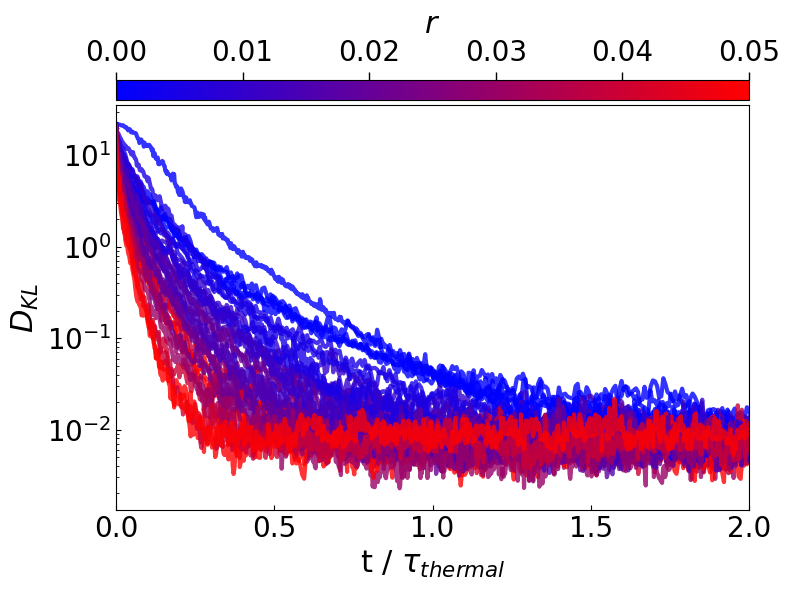

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)

platue_indices_per_r_per_start = []
mean_platue_indices_per_r_per_start = []
std_platue_indices_per_r_per_start = []

for KLDS_per_rate_per_batch in KLDs_per_BR_per_start:
    platue_indices_per_r = []
    for klds_per_batch in KLDS_per_rate_per_batch:
        platue_index_per_r = []
        kld_thresholds = []
        for kld_per_time in klds_per_batch:
            kld_threshold = np.mean(kld_per_time[-50:])
            kld_threshold_std = np.std(kld_per_time[-50:])
            kld_threshold = kld_threshold + 10*kld_threshold_std
            kld_thresholds.append(kld_threshold)
        kld_threshold = np.max(kld_thresholds)
        print('KLD threshold:', kld_threshold)
        for kld_per_time, r, c in zip(klds_per_batch, resetting_rates, colors):
            '''
            kld_threshold = np.mean(kld_per_time[-50:])
            kld_threshold_std = np.std(kld_per_time[-50:])
            kld_threshold = kld_threshold + 3*kld_threshold_std
            '''
            platue_index = np.where(kld_per_time < kld_threshold)[0][0]
            timestep_platue = timesteps[platue_index]*dt
            adjusted_platue = timestep_platue/typical_relaxation_time
            platue_index_per_r.append(adjusted_platue)
        platue_indices_per_r.append(platue_index_per_r)
    platue_indices_per_r = np.array(platue_indices_per_r)
    mean_platue_indices_per_r = np.mean(platue_indices_per_r, axis=0)
    std_platue_indices_per_r = np.std(platue_indices_per_r, axis=0)
    platue_indices_per_r_per_start.append(platue_indices_per_r)
    mean_platue_indices_per_r_per_start.append(mean_platue_indices_per_r)
    std_platue_indices_per_r_per_start.append(std_platue_indices_per_r)
    for kld_per_time, platue, r, c in zip(KLDS_per_rate_per_batch[0], mean_platue_indices_per_r, resetting_rates, colors):
        adjusted_timesteps = timesteps*dt/typical_relaxation_time
        adjusted_timesteps = adjusted_timesteps/mean_platue_indices_per_r[0]
        adjusted_platue = platue/mean_platue_indices_per_r[0]
        im=ax.plot(adjusted_timesteps,kld_per_time, label=f'{r:.3f}', color=cpick.to_rgba(r), lw=3, alpha=0.8)
        #im=ax.axvline(adjusted_platue, color=cpick.to_rgba(r), linestyle='--')
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=20, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$r$', fontsize=22)
kld_line_handle = plt.Line2D([0],[0],linestyle='-',color='Black', label='KLD')
platue_index_handle = plt.Line2D([0],[0],linestyle='--',color='Black', label=f'$\\tau_R$')
resetting_rate_handles = []
for r, c in zip(resetting_rates, colors):
    h = plt.bar([0],[0],color=cpick.to_rgba(r),label=f'r={r:.3f}')
    resetting_rate_handles.append(h)
handles = [kld_line_handle, platue_index_handle] + resetting_rate_handles
ax.set_xlabel('t / $\\tau_{thermal}$', fontsize=22)
ax.set_ylabel('$D_{KL}$',fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlim(0, 2)
ax.set_yscale('log')
plt.tight_layout()
figname = 'b - KLD by steps - Harmonic.png'
path = os.path.join('Figure5',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()
platue_indices_per_r_per_start = np.array(platue_indices_per_r_per_start)
mean_platue_indices_per_r_per_start = np.array(mean_platue_indices_per_r_per_start)
std_platue_indices_per_r_per_start = np.array(std_platue_indices_per_r_per_start)
np.save(folder+'/platue_indices_per_r_per_start.npy', platue_indices_per_r_per_start)
np.save(folder+'/mean_platue_indices_per_r_per_start.npy', mean_platue_indices_per_r_per_start)
np.save(folder+'/std_platue_indices_per_r_per_start.npy', std_platue_indices_per_r_per_start)

In [67]:
platue_indices_per_r_per_start = np.load(folder+'/platue_indices_per_r_per_start.npy', allow_pickle=True)
mean_platue_indices_per_r_per_start = np.load(folder+'/mean_platue_indices_per_r_per_start.npy', allow_pickle=True)
std_platue_indices_per_r_per_start = np.load(folder+'/std_platue_indices_per_r_per_start.npy', allow_pickle=True)

In [68]:
print('Mean Platue Indices per r per start:', mean_platue_indices_per_r_per_start)
print('Std Platue Indices per r per start:', std_platue_indices_per_r_per_start)

Mean Platue Indices per r per start: [[0.77   0.6025 0.49   0.43   0.3675 0.31   0.275  0.235 ]
 [0.7575 0.6575 0.5575 0.4625 0.39   0.2975 0.2525 0.24  ]
 [0.8075 0.655  0.505  0.445  0.4075 0.31   0.2825 0.22  ]
 [1.5475 0.98   0.68   0.5875 0.46   0.355  0.3225 0.24  ]
 [2.505  1.565  1.2275 1.0125 0.8225 0.585  0.4275 0.3775]]
Std Platue Indices per r per start: [[0.02   0.0225 0.005  0.     0.0075 0.015  0.02   0.005 ]
 [0.0125 0.0075 0.0175 0.0075 0.035  0.0025 0.0075 0.03  ]
 [0.0675 0.06   0.105  0.035  0.0075 0.05   0.0425 0.015 ]
 [0.0025 0.01   0.045  0.0325 0.     0.025  0.0225 0.015 ]
 [0.075  0.005  0.0025 0.1075 0.0325 0.01   0.0125 0.0275]]


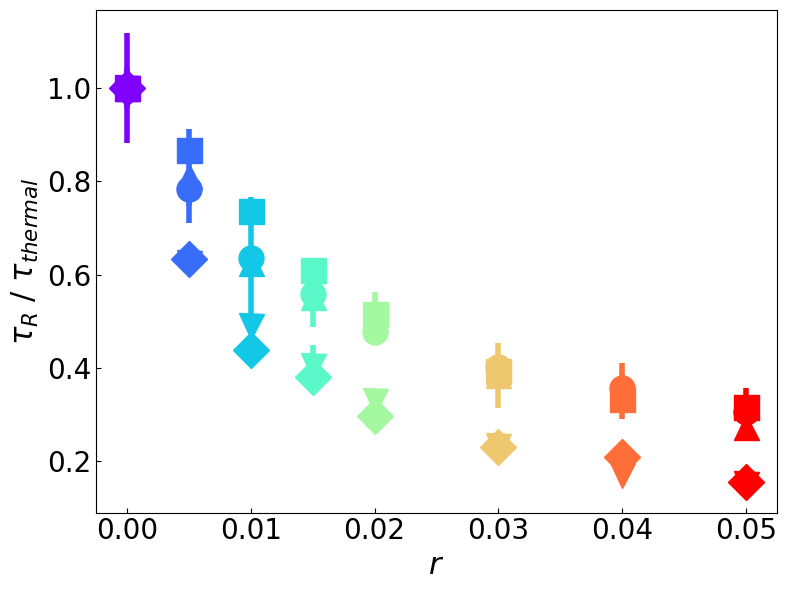

In [69]:
fig, ax = plt.subplots(figsize=(8, 6))
colors_resetting = [cpick.to_rgba(r) for r in resetting_rates]
sybols_per_start = ['o', 's', '^', 'D', 'v']
for i, (mean_platue_indices_per_r, std_platue_indices_per_r, symbol) in enumerate(zip(mean_platue_indices_per_r_per_start, std_platue_indices_per_r_per_start, sybols_per_start)):
    for i, (r, c) in enumerate(zip(resetting_rates, resetting_colors)):
        yerr = np.sqrt((std_platue_indices_per_r[i]/mean_platue_indices_per_r[0])**2 + ((mean_platue_indices_per_r[i]*std_platue_indices_per_r[0])/(mean_platue_indices_per_r[0]**2))**2)
        ax.errorbar(resetting_rates[i], mean_platue_indices_per_r[i]/mean_platue_indices_per_r[0], yerr=yerr, linestyle='--', marker = symbol, lw=4, ms=18, color=c)
ax.set_xlabel('$r$', fontsize=22)
ax.set_ylabel('$\\tau_R$ / $\\tau_{thermal}$', fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
fig.tight_layout()
figname = 'c - Relaxation by resetting rate - Harmonic.png'
path = os.path.join('Figure5',figname)
#plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
plt.show()

In [70]:
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}' 
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
np.save(folder+f'/mean_platue_indices_per_r.npy', mean_platue_indices_per_r)
np.save(folder+f'/std_platue_indices_per_r.npy', std_platue_indices_per_r)
np.save(folder+f'/resetting_rates.npy', np.array(resetting_rates))